# TexAnASD - Text Analytics for ASD Risk Gene Predictions
- IEEE BIBM 2019 - Workshop on Machine Learning and Artificial Intelligence in Bioinformatics and Medical Informatics
- San Diego, CA, USA, November 18 - 21, 2019

In [1]:
import numpy as np
import pandas as pd

from time import time
import datetime
import os
import logging

import seaborn as sns
import matplotlib.pyplot as plt 


import json                  # For reading config. / and managing objects
import ast

import concurrent.futures

from omim import generateOMIM_ids
from omim import readOmimDataFromWeb, processOmimDataFiles

from omim_pipeline import plotROC, plotROC_Model
from omim_pipeline import shuffleData, cross_validation_split
from omim_pipeline import runPipeline,runParallelCrossValidation
from omim_pipeline import runModelTrainTest

from auxiliary_func import save_obj, load_obj, read_config

[nltk_data] Downloading collection 'all-corpora'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /home/jpastorino/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/jpastorino/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /home/jpastorino/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /home/jpastorino/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /home/jpastorino/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /home/jpastorino/nltk_data...
[nltk_data]    |   Package cess_cat is alr

# Configuration

In [2]:
RUN_ID = datetime.datetime.now().strftime("%Y%m%d_%H%M")

CONST_MODE_SEQUENTIAL = 0
CONST_MODE_PARALLEL   = 1
 
config = read_config('./config.json')

In [3]:
LOG = config["app"]["LOG_DIR"]+"omim_"+RUN_ID+".log"

OMIM_PATH           = config["omim"]["OMIM_PATH"]
OMIM_GENE_PATH      = config["omim"]["OMIM_GENE_PATH"]
OMIM_PROC_PATH      = config["omim"]["OMIM_PROC_PATH"]
READ_OMIM_FROM_WEB  = ast.literal_eval(config["omim"]["READ_OMIM_FROM_WEB"])
READ_OMIM_FROM_FILE = ast.literal_eval(config["omim"]["READ_OMIM_FROM_FILE"])

DATA_PATH          = config["app"]["DATA_PATH"]
PROJECT_DATA       = config["app"]["PROJECT_DATA"]
OMIM_IDS_FILE      = config["app"]["OMIM_IDS_FILE"]
GENERATE_OMIM_IDS  = ast.literal_eval(config["app"]["GENERATE_OMIM_IDS"])

In [4]:
if config["omim"]["LIMIT_SAMPLES_NO"]<=0:
    LIMIT_SAMPLE_NUMBER = None
else:
    LIMIT_SAMPLE_NUMBER = config["omim"]["LIMIT_SAMPLES_NO"]

print("Using {} as sample limit for the training model.".format(LIMIT_SAMPLE_NUMBER))

Using None as sample limit for the training model.


In [5]:
logging.basicConfig(filename=LOG, 
                    format=config["app"]["LOG_FORMAT"], 
                    level=config["app"]["LOG_LEVEL"], 
                    datefmt=config["app"]["LOG_DATE_FORMAT"]
                   )
logging.info('Started Run ID:'+RUN_ID)

# 1. Generate Genes ID and Mappings
String database and *forecASD* use protein ids. To be able to compare we need to restrict to the same genes for those proteins. We also need the same mappings from entrez to omim ids to retrieve the data from the web.

In [6]:
if GENERATE_OMIM_IDS:
#     print("Generating the new omim mapping file...")
    logging.info("Generating the new omim mapping file...")
    df_req_omim_ids = generateOMIM_ids(config["omim"]["OMIM_TO_GENE_FILE"], config["stringdb"]["PROTEIN_INFO_FILE"], 
                                       config["sfari"]["SFARI_GENE_FILE"], OMIM_IDS_FILE)
else:
#     print("Using previously generated OMIM_ID list.")
    logging.info("Using previously generated OMIM_ID list.")
    df_req_omim_ids = pd.read_csv(OMIM_IDS_FILE)


# 2. Retrieve and Process OMIM Data

## Read Gene list to retrieve data from OMIM

### Data Columns:
- **HGNC**:          HUGO Gene Nomenclature Committee gene name
- **Entrez_ID**:     Entrez Id number
- **OMIM_ID**:       Omim id number
- **ENSEMBL_ID**:    Ensembl Gene Id


In [7]:
df_omim_ids = pd.read_csv(OMIM_IDS_FILE)

## Read OMIM Data From the web.

### API summary
```
https://api.omim.org/api/entry/search?search=approved_gene_symbol:ARF5&apiKey=<apiKey>&format=json
https://api.omim.org/api/entry?mimNumber=<omimid>&apiKey=<apiKey>&format=json&include=all
```

In [8]:
if READ_OMIM_FROM_WEB:
    logging.info("Reading Omim from web.")
    readOmimDataFromWeb(df_omim_ids, OMIM_GENE_PATH, config )
else:
    #print("Using previously downloaded files("+str(len(os.listdir(OMIM_GENE_PATH)))+").")
    logging.info("Using previously downloaded files("+str(len(os.listdir(OMIM_GENE_PATH)))+").")

## Process OMIM Data Files

In [9]:
if not READ_OMIM_FROM_FILE:
    logging.info("Processing OMIM files.")
    df_omim_info = processOmimDataFiles(df_omim_ids, OMIM_GENE_PATH, OMIM_PROC_PATH+"/omim_summary.csv")
else:
    logging.info("Using previously computed features.")
    df_omim_info = pd.read_csv(OMIM_PROC_PATH+"/omim_summary.csv")

print()
print("Number of Genes from Omim Data: {}. \nNumber of features for each gene: {}".format(df_omim_info.shape[0],df_omim_info.shape[1]))


Number of Genes from Omim Data: 14551. 
Number of features for each gene: 103


/home/jpastorino/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8,13,33,47,60,67) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Merging Text with Class and saving to file. 

In [10]:
df_omimtext = df_omim_info[["gene","text"]].merge(df_omim_ids, left_on="gene",right_on="HGNC")[["gene","text","ASD"]]
logging.info("Saving omim info and class to file...")
df_omimtext.to_csv(OMIM_PROC_PATH+"/omim_text_and_class.csv",index=False)
logging.info("Done!")

# 3. Split Train and Test Datasets

- previous work results (to compare AUC and plot ROC)

In [11]:
logging.info("Reading forecASD results.")
df_forecASD_results = pd.read_csv(config["forecasd"]["results_file"])
df_forecASD_results = pd.read_csv("./data/forecASD/forecASD_table.csv") # Data generated by running the code.
df_forecASD_results = df_forecASD_results[["ensembl_string","forecASD","STRING_score","BrainSpan_score","krishnan_post","Netscore","rASD","SFARI_listed",]].copy()
logging.info("Done!")

- previous work test data (obtaining by saving temporal objects into files)

In [12]:
logging.info("Reading forecASD test data.")
df_forecASD_test      = pd.read_csv(config["forecasd"]["test_file"])
df_forecASD_test_cols = df_forecASD_test.columns.tolist(); df_forecASD_test_cols[0]="ENSP"; df_forecASD_test.columns=df_forecASD_test_cols
df_forecASD_test      = df_forecASD_test[["ENSP"]].copy()
logging.info("Done!")

- previous work results for test data only.

We consider test data that we are using as test data. This will allow us to compute a new AUC-ROC and be able to compare our accuracy and the previous works accurace. 

In [13]:
df_forecASD_test_results = df_forecASD_results.merge(df_req_omim_ids, left_on="ensembl_string", right_on="ENSP")[["ENSP","HGNC",
                                                                                                                  "forecASD","STRING_score","BrainSpan_score","krishnan_post",
                                                                                                                  "SFARI_listed","ASD"]]

df_forecASD_test_results = df_forecASD_test_results.merge(df_forecASD_test).copy()

In [14]:
logging.info("ForecASD test shape {}".format(df_forecASD_test.shape))
logging.info("ForecASD test results shape {}".format(df_forecASD_test_results.shape))

- Proteins list in test and not in test in previous works.

We can use these lists for train and test purposes. 

In [15]:
logging.info("Computing train set...")
lst_test_values_notin_test_results = [i for i in df_omimtext["gene"].tolist() if i not in df_forecASD_test_results["HGNC"].tolist()]
lst_test_values_notin_test_results = list(set(lst_test_values_notin_test_results))
logging.info("Done!")

In [16]:
logging.info("Computing test set...")
lst_test_values_in_test_results = [i for i in df_omimtext["gene"].tolist() if i in df_forecASD_test_results["HGNC"].tolist()]
lst_test_values_in_test_results = list(set(lst_test_values_in_test_results))
logging.info("Done!")

In [17]:
logging.info("The number of samples usable for test purposes is {}".format(len(lst_test_values_in_test_results)))
logging.info("The number of samples usable for train purposes is {}".format(len(lst_test_values_notin_test_results)))

#### Computing Train and Test Splits

In [18]:
logging.info("Generating train and test samples.")
df_test_lst  = pd.DataFrame(lst_test_values_in_test_results,columns=["gene"])
df_train_lst = pd.DataFrame(lst_test_values_notin_test_results,columns=["gene"])
df_test_samples  = df_omimtext.merge(df_test_lst)
df_train_samples = df_omimtext.merge(df_train_lst)

# Limiting if argument is set.
df_test_samples  = df_test_samples[:LIMIT_SAMPLE_NUMBER]
df_train_samples = df_train_samples[:LIMIT_SAMPLE_NUMBER]

In [19]:
if config["app"]["SAVE_TRAIN_TEST_DF"]:
    df_train_samples[["gene",'ASD']].to_csv(PROJECT_DATA+"/train_samples_labels.csv")
    df_test_samples[["gene",'ASD']].to_csv(PROJECT_DATA+"/test_samples_labels.csv")

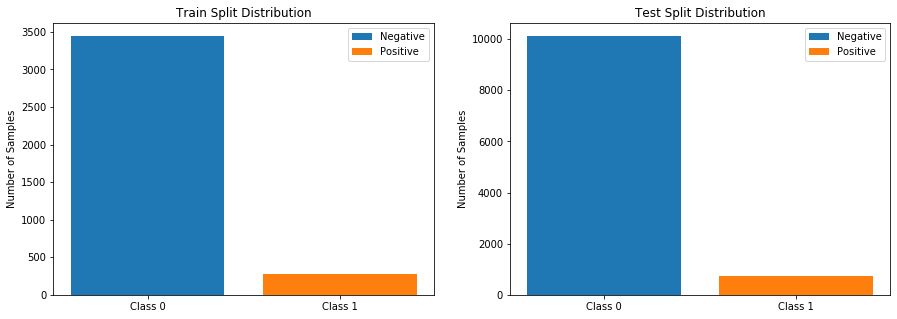

In [20]:
df_tr_tmp = df_train_samples.copy()
df_ts_tmp = df_test_samples.copy()
 
# Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15,5))

ax1.bar(["Class 0"],df_tr_tmp[df_tr_tmp["ASD"]==0].count()[0], label="Negative")
ax1.bar(["Class 1"],df_tr_tmp[df_tr_tmp["ASD"]==1].count()[0], label="Positive")

ax1.set_ylabel('Number of Samples')
ax1.set_title('Train Split Distribution')
ax1.legend()

ax2.bar(["Class 0"],df_ts_tmp[df_ts_tmp["ASD"]==0].count()[0], label="Negative")
ax2.bar(["Class 1"],df_ts_tmp[df_ts_tmp["ASD"]==1].count()[0], label="Positive")

ax2.set_ylabel('Number of Samples')
ax2.set_title('Test Split Distribution')
ax2.legend()

try: os.makedirs("./images")
except: pass
plt.savefig("./images/train_test_distribution_2.eps", format="eps",dpi=1200,)

# 4. Cross-validation

## Cross Validation Split. 

In [21]:
def main_cross_validation_split():
    global train_samples, train_labels, test_samples, test_labels, data_folds
    
    if config["app"]["COMPUTE_SPLITS"]:
        logging.info("Computing Train/Test-corpus/class Splits")
        arr_train_samples = df_train_samples["text"].values
        arr_train_labels  = df_train_samples["ASD"].values

        arr_test_samples  = df_test_samples["text"].values
        arr_test_labels   = df_test_samples["ASD"].values

        train_samples, train_labels = shuffleData(arr_train_samples, arr_train_labels)
        test_samples,  test_labels  = shuffleData(arr_test_samples,  arr_test_labels)

        data_folds = cross_validation_split(train_samples, train_labels, k_folds=config["app"]["K_FOLDS"])

        for i in range(len(data_folds)):
            tmp_no_samples      = len(data_folds[i]["labels"])
            tmp_pos_samples     = np.array(data_folds[i]["labels"]).sum()
            tmp_pos_samples_pct = np.round(tmp_pos_samples/tmp_no_samples*100,2)

            logging.info("{}-Fold length is {} samples and {} labels. {:3d} ({:3.2f}%) positive samples".format( i, len(data_folds[i]["data"]), 
                                                                                                                tmp_no_samples,tmp_pos_samples,tmp_pos_samples_pct))


        save_obj(train_samples, PROJECT_DATA+"/computed_data/"+ "train_samples"   +".pkl")
        save_obj(test_samples,  PROJECT_DATA+"/computed_data/"+ "test_samples"    +".pkl")
        save_obj(train_labels,  PROJECT_DATA+"/computed_data/"+ "train_labels"    +".pkl")
        save_obj(test_labels,   PROJECT_DATA+"/computed_data/"+ "test_labels"     +".pkl")

        for i in range(len(data_folds)):
            save_obj(data_folds[i], PROJECT_DATA+"/computed_data/"+ "fold_{:02d}_data".format(i) +".pkl")

    else:
        logging.info("READING Train/Test-corpus/class Splits from files.")

        train_samples = load_obj(PROJECT_DATA+"/computed_data/"+ "train_samples"   +".pkl")
        test_samples  = load_obj(PROJECT_DATA+"/computed_data/"+ "test_samples"    +".pkl")
        train_labels  = load_obj(PROJECT_DATA+"/computed_data/"+ "train_labels"    +".pkl")
        test_labels   = load_obj(PROJECT_DATA+"/computed_data/"+ "test_labels"     +".pkl")

        data_folds = []
        for i in range(config["app"]["K_FOLDS"]):
            tmp_i_fold = load_obj(PROJECT_DATA+"/computed_data/"+ "fold_{:02d}_data".format(i) +".pkl")
            data_folds.append(tmp_i_fold)

            tmp_no_samples      = len(tmp_i_fold["labels"])
            tmp_pos_samples     = np.array(tmp_i_fold["labels"]).sum()
            tmp_pos_samples_pct = np.round(tmp_pos_samples/tmp_no_samples*100,2)

            logging.info("{}-Fold length is {} samples and {} labels. {:3d} ({:3.2f}%) positive samples".format( i, len(tmp_i_fold["data"]), 
                                                                                                                tmp_no_samples,tmp_pos_samples,tmp_pos_samples_pct))

## Oversampling
As our train data is too skewed, we oversample positive samples in order to reduce the skew effect. 
The oversample consists on simple duplicate the positive samples as many times as the number of positive and negative samples are similar. 

In [22]:
def main_oversampling():
    global train_samples, train_labels, test_samples, test_labels, data_folds
    
    logging.info("Reducing data Skew by OverSampling...")
    for i in range(len(data_folds)):
        tmp_pos_samples     = np.array(data_folds[i]["labels"]).sum()
        tmp_neg_samples     = len(data_folds[i]["labels"]) - tmp_pos_samples

        logging.info("<OS> {}-Fold: Initial {:4d} negative, {:4d} positive, {:2d}-1 ratio.".format(i,tmp_neg_samples,tmp_pos_samples,tmp_neg_samples//tmp_pos_samples ))
        logging.info("<OS> {}-Fold: Copying {:4d} times the positive samples.".format(i,tmp_neg_samples//tmp_pos_samples))

        tmp_pos_cpy_sample = []
        tmp_pos_cpy_label  = []

        for j in range(len(data_folds[i]["labels"])):
            if data_folds[i]["labels"][j]==1:
                tmp_pos_cpy_sample.append(data_folds[i]["data"][j])
                tmp_pos_cpy_label.append(data_folds[i]["labels"][j])


        for j in range(tmp_neg_samples//tmp_pos_samples-1):
            data_folds[i]["data"].extend(tmp_pos_cpy_sample)
            data_folds[i]["labels"].extend(tmp_pos_cpy_label)

        tmp_pos_samples     = np.array(data_folds[i]["labels"]).sum()
        tmp_neg_samples     = len(data_folds[i]["labels"]) - tmp_pos_samples

        logging.info("<OS> {}-Fold: Final   {:4d} negative, {:4d} positive, {:2d}-1 ratio.".format(i,tmp_neg_samples,tmp_pos_samples,tmp_neg_samples//tmp_pos_samples ))

    logging.info("Oversampling... Done!")

## Running Cross-Validation

In [23]:
def main_run_cross_validation(iteration=0, parameters=None):
    global train_labels, train_labels, test_samples, test_labels, data_folds
    if config["app"]["PROC_MODE"] == CONST_MODE_PARALLEL:
        t0=time()
        auc_per_fold =[]
        scores=[]
        fold_range = range (config["app"]["K_FOLDS"])

        args = [ (i, data_folds, PROJECT_DATA+"crossvalidation/", iteration, parameters) for i in fold_range ]

        with concurrent.futures.ProcessPoolExecutor() as executor:
            for number, result_score in zip(fold_range, executor.map(runParallelCrossValidation, *zip(*args) )):
                auc_per_fold.append(result_score['auc'])
                scores.append(result_score)

        t1=time()
        logging.info("Cross-Validation Ran in {:.3f} sec and achieved an average accuracy of {:.3f} with Min:{:.3f} and Max:{:.3f}".format(t1-t0, np.mean(auc_per_fold), np.min(auc_per_fold), np.max(auc_per_fold) ))

        return auc_per_fold, scores

## Cross-Validation Main Pipeline

In [24]:
if config["app"]["TEST_MAIN_PIPELINE"]:
    main_cross_validation_split()
    main_oversampling()
    scores = main_run_cross_validation() 

# 5.Parameter Tuning


- **C** : float, optional (default=1.0):    Penalty parameter C of the error term.
- **kernel** : string, optional (default=’rbf’)    Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples). 
- **degree** : int, optional (default=3)    Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
- **gamma** : float, optional (default=’auto’) Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.  Current default is ‘auto’ which uses 1 / n_features, if gamma='scale' is passed then it uses 1 / (n_features * X.var()) as value of gamma. The current default of gamma, ‘auto’, will change to ‘scale’ in version 0.22. ‘auto_deprecated’, a deprecated version of ‘auto’ is used as a default indicating that no explicit value of gamma was passed.
- **coef0** : float, optional (default=0.0)    Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’.
- **shrinking** : boolean, optional (default=True)    Whether to use the shrinking heuristic.
- **probability** : boolean, optional (default=False)    Whether to enable probability estimates. This must be enabled prior to calling fit, and will slow down that method.
- **tol** : float, optional (default=1e-3)    Tolerance for stopping criterion.
- **class_weight** : {dict, ‘balanced’}, optional    Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
- **max_iter** : int, optional (default=-1)    Hard limit on iterations within solver, or -1 for no limit.

### Reading Configuration of Parameters


In [25]:
if config["app"]["RUN_PARAM_TUNING"]:
    df_param_tuning = pd.read_csv(config["app"]["PARAM_FILE"], comment="#", skip_blank_lines=True)
    df_param_tuning.reset_index(inplace=True)
    parameter_list =[]
    for i,row in df_param_tuning[:2].iterrows():
        param ={}
        for c in df_param_tuning.columns:
            param[c]=row[c]
        parameter_list.append(param)


## Running test on Parameters

In [26]:
if config["app"]["RUN_PARAM_TUNING"]:

    if not os.path.exists(config["app"]["PARAM_TUNING_FILE"]): add_header=True
    else: add_header=False
        
    param_tun_file = open(config["app"]["PARAM_TUNING_FILE"],"a")
    if add_header:
        param_tun_file.write("param_set_id,metric,min,avg,max\n")
    
    # Same data distribution for all!
    main_cross_validation_split()
    main_oversampling()
        
    for param_set in parameter_list:

        index = param_set.pop("index")

        if param_set["class_weight"]=="None":
            param_set.pop("class_weight")

        auc_scores, scores = main_run_cross_validation(parameters=param_set) 
        
        for metric in ['auc','accuracy','recall','precision', 'F1']:
            tmp=[]
            for i in range(len(scores)):
                tmp.append(scores[i][metric])
            param_tun_file.write("{:03},{},{:.6f},{:.6f},{:.6f}\n".format(index,metric,np.min(tmp),np.mean(tmp),np.max(tmp)))

    param_tun_file.close()

In [27]:
df_param_tuning_results = pd.read_csv(config["app"]["PARAM_TUNING_FILE"], comment="#", skip_blank_lines=True)

In [28]:
bests_metrics = []
for metric in ['auc','accuracy','recall','precision', 'F1']:
    #print(df_param_tuning_results[df_param_tuning_results["metric"]==metric].sort_values(by="avg", ascending=False)[:1])
    bests_metrics.append(df_param_tuning_results[df_param_tuning_results["metric"]==metric].sort_values(by="avg", ascending=False)[:1]["param_set_id"].values[0])

#bests_metrics
#df_param_tuning_results[df_param_tuning_results["param_set_id"].isin( bests_metrics)].sort_values(by="metric")
    

In [29]:
df_param_tuning=pd.read_csv(config["app"]["PARAM_FILE"], comment="#", skip_blank_lines=True).reset_index()
#df_param_tuning[df_param_tuning["index"].isin(bests_metrics)]

## Parameter Reading Function
Read the parameter file and extract the parameter configuration for the model based on the config.file CHOOSEN_PARAMETER_ID.

In [30]:
def get_model_parameters():
    df_param_tuning=pd.read_csv(config["app"]["PARAM_FILE"], comment="#", skip_blank_lines=True).reset_index()

    for i,row in df_param_tuning[df_param_tuning["index"]==config["app"]["CHOOSEN_PARMETER_ID"]].iterrows():
        param ={}
        for c in df_param_tuning.columns:
            param[c]=row[c]
    
    #Removing index
    index = param.pop("index")

    if param["class_weight"]=="None":
        param.pop("class_weight")

    return param

# 6.Full Cross-Validation

In [31]:
if config["app"]["RUN_CROSS_VAL_ITER"]:
    all_iter_auc = []
    all_iter_t0 = time()

    parameters = get_model_parameters()

    for iter in range(config["app"]["K_FOLDS"]):
        logging.info("=== Running Iteration {} ===".format(iter))
        main_cross_validation_split()
        main_oversampling()
        tmp_auc, tmp_scores = main_run_cross_validation(iteration=iter, parameters=parameters)
        all_iter_auc.extend(tmp_auc)

    all_iter_t1 = time()
    logging.info("=== Done With Iterations ===")
    logging.info("{}-fold Cross-Validation Iterations Ended. Process runtime {:3.2f}sec.".format(config["app"]["K_FOLDS"], all_iter_t1-all_iter_t0))
    logging.info("{}-fold Cross-Validation Iterations Average AUC was {:3.5f}.".format(          config["app"]["K_FOLDS"], np.mean(all_iter_auc)))
else:
    logging.info("Skipping Cross-Validation")

# 7.Training and Testing the Model with all Data

## Train/Test Split Proper Formating. 
```train_labels, train_labels``` will be the training set and 
```test_samples, test_labels``` will be the testing set.

We reuse the ```main_cross_validation_split()``` method used for cross-validation.

## Oversampling
As our train data is too skewed, we oversample positive samples in order to reduce the skew effect. 
The oversample consists on simple duplicate the positive samples as many times as the number of positive and negative samples are similar. 

In [32]:
def main_train_test_oversampling():
    global train_samples, train_labels, test_samples, test_labels
    
    logging.info("Reducing data Skew by OverSampling Train Data...")
    
    tmp_pos_samples     = np.array(train_labels).sum()
    tmp_neg_samples     = len(train_labels) - tmp_pos_samples

    logging.info("<OS> Train: Initial {:4d} negative, {:4d} positive, {:2d}-1 ratio.".format(tmp_neg_samples,tmp_pos_samples,tmp_neg_samples//tmp_pos_samples ))
    logging.info("<OS> Train: Copying {:4d} times the positive samples.".format(tmp_neg_samples//tmp_pos_samples))

    tmp_pos_cpy_sample = []
    tmp_pos_cpy_label  = []

    for j in range(len(train_labels)):
        if train_labels[j]==1:
            tmp_pos_cpy_sample.append(train_samples[j])
            tmp_pos_cpy_label.append(train_labels[j])


    for j in range(tmp_neg_samples//tmp_pos_samples-1):
        train_samples.extend(tmp_pos_cpy_sample)
        train_labels.extend(tmp_pos_cpy_label)

    tmp_pos_samples     = np.array(train_labels).sum()
    tmp_neg_samples     = len(train_labels) - tmp_pos_samples

    logging.info("<OS> Train: Final   {:4d} negative, {:4d} positive, {:2d}-1 ratio.".format(tmp_neg_samples,tmp_pos_samples,tmp_neg_samples//tmp_pos_samples ))
    logging.info("Oversampling... Done!")

## Running Model Train/Test

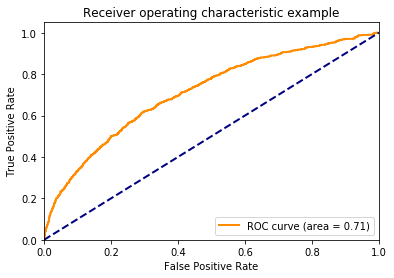

In [33]:
t0        = time()

parameters = get_model_parameters()

main_cross_validation_split()
main_train_test_oversampling()

scores = runModelTrainTest(train_samples, train_labels, test_samples, test_labels, output_path=PROJECT_DATA+"output/", parameters=parameters)

t1=time()

logging.info("Main Program completed. Runtime was {:.3f} sec.".format(t1-t0))
logging.info("AUC:{:.3f}. Accuracy{:.3f}. Recall{:.3f}. Precision{:.3f}. F1{:.3f}.".format(scores["auc"],scores["accuracy"],scores["recall"],scores["precision"],scores["F1"]) )


In [34]:
scores

{'auc': 0.7124840011338793,
 'accuracy': 0.8153605304355834,
 'recall': 0.42934782608695654,
 'precision': 0.16622830089426618,
 'F1': 0.2396662874478574}

In [35]:
logging.info("=== Done! Main Program Ended ===")